1. Ensemble learning involves a combination of techniques that allows multiple machine learning models, called base learners (or, sometimes, weak learners), to consolidate their predictions and output a single, optimal prediction, given their respective inputs and outputs.

2. error = (bias^2)+ variance + irreducible error



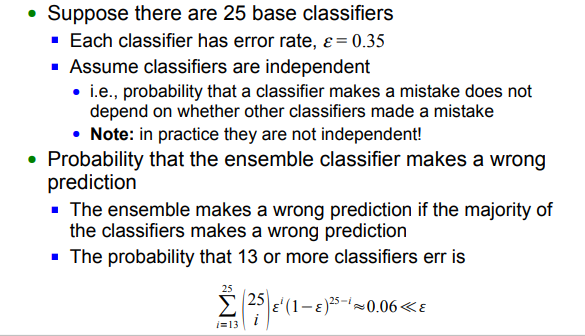



As is evident, the more base learners we add to the ensemble, the more accurate the ensemble will be, under the condition that each learner is uncorrelated to the others. Of course, this is increasingly difficult to achieve. Furthermore, the law of diminishing returns applies. Each new uncorrelated base learner contributes less to the overall error reduction than the previously added base learner. The following figure shows the ensemble error percentage for a number of uncorrelated base learners. As is evident, the greatest reduction is applied when we add two uncorrelated base learners




#### Identifying bias and variance
Although bias and variance have theoretical formulas, it is difficult to calculate their actual values. A simple way to estimate them empirically is with learning and validation curves.

## Ensemble methods

Ensemble methods are divided into two major classes or taxonomies: generative and non-generative methods.

### 1. Non-generative:

1. Non-generative methods are focused on combining the predictions of a set of pretrained models.
2. These models are usually trained independently of one another, and the ensemble algorithm dictates how their predictions will be combined.
3. Base classifiers are not affected by the fact that they exist in an ensemble.

In this book, we will cover two main non-generative methods: voting and stacking.

#### 1. Voting:
1. Refers to techniques that allow models to vote in order to produce a single answer, similar to how individuals vote in national elections.
2. The most popular (most voted for) answer is selected as the winner.

#### 2.Stacking:
1. Refers to methods that utilize a model (the meta-learner) that learns how to best combine the base learner's predictions.
2. Although stacking entails the generation of a new model, it does not affect the base learners, thus it is a non-generative method.


### 2.Generative methods
1. They are able to generate and affect the base learners that they use.
2. They can either tune their learning algorithm or the dataset used to train them, in order to ensure diversity and high model performance.
3. Furthermore, some algorithms can induce randomness in models, in order to further enforce diversity.

The main generative methods that we will cover in this book are bagging, boosting, and random forests. 



#### 1. Bagging
1. Bagging aims to reduce variance.
2. The bagging algorithm resamples instances of the training dataset, creating many individual and diverse datasets, originating from the same dataset.
3. Afterward, a separate model is trained on each sampled dataset, forcing diversity between the ensemble models.

#### 2. Boosting:
1. Boosting is a technique mainly targeting biased models.
2. Its main idea is to sequentially generate models, such that each new model addresses biases inherent in the previous models.
3. Thus, by iteratively correcting previous errors, the final ensemble has a significantly lower bias.

#### 3.Random Forests
1. It is similar to bagging, in that it resamples from the training dataset.
2. Instead of sampling instances, it samples features, thus creating even more diverse trees, as features strongly correlated to the target may be absent in many trees.


#### Conclusion
Ensemble Methods can be used for various reasons, mainly to:
1. Decrease Variance (Bagging)
2. Decrease Bias (Boosting)
3. Improve Predictions (Stacking)

# STACKING

Stacking is a form of meta-learning. The main idea is that we use base learners in order to generate metadata for the problem's dataset and then utilize another learner called a meta-learner, in order to process the metadata.

Base learners are considered to be level 0 learners, while the meta learner is considered a level 1 learner. In other words, the meta learner is stacked on top of the base learners, hence the name stacking.
 
A more intuitive way to describe the ensemble is to present an analogy with voting. In voting, we combined a number of base learners' predictions in order to increase their performance. In stacking, instead of explicitly defining the combination rule, we train a model that learns how to best combine the base learners' predictions

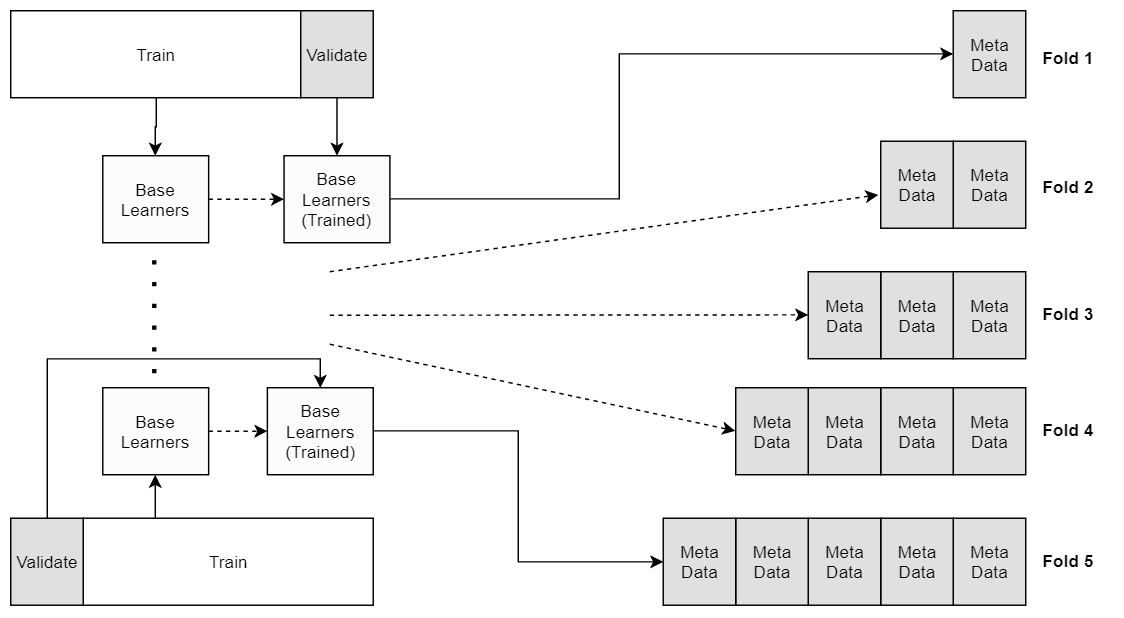



###### K-fold cross validation
the preferred approach is to utilize K-fold cross validation. For each K, the base learners will be trained on the K-1 folds and predict on the Kth fold, generating 100/K percent of the final training metadata. By repeating the process K times, one for each fold, we will have generated metadata for the whole training dataset. 

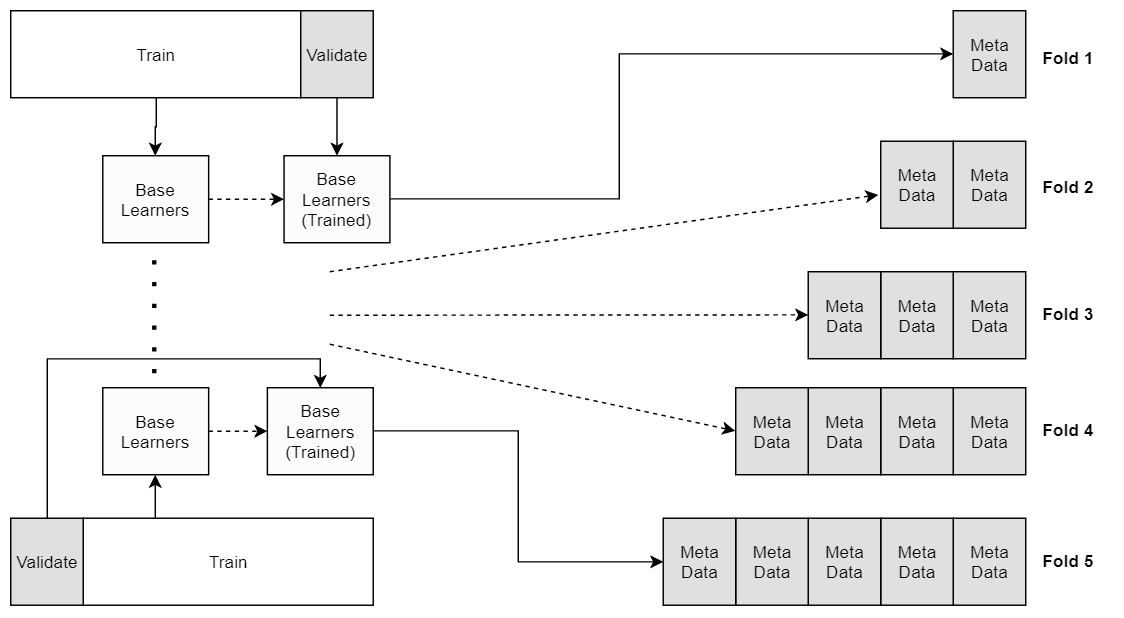


##### Selecting base learners:
It is generally a good idea to mix different learning algorithms, in order to capture both linear and non-linear relationships between the features themselves, as well as the target variable


##### Selecting the meta-learner
Generally, the meta-learner should be a <b>relatively simple machine learning algorithm </b>, in order to avoid overfitting.

Furthermore, additional steps should be taken in order to regularize the meta-learner.
For example,
1. if a decision tree is used, then the tree's maximum depth should be limited.
2. If a regression model is used, a regularized regression (such as elastic net or ridge regression) should be preferred. 

If there is a need for more complex models in order to increase the ensemble's predictive performance, a multi-level stack could be used, in which the number of models and each individual model's complexity reduces as the stack's level increases:

<i>Another really important characteristic of the meta-learner should be the ability to handle correlated inputs and especially to not make any assumptions about the independence of features from one another, as naive Bayes classifiers do. The inputs to the meta-learner (metadata) will be highly correlated. This happens because all base learners are trained to predict the same target. Thus, their predictions will come from an approximation of the same function. Although the predicted values will vary, they will be close to each other </i>

#### Stacking python implementation

1. dataset: diabetes regression
2. Ensemble:
    1. 5-neighbor k-Nearest Neighbors (k-NN)
    2. decision tree limited to a max depth of four
    3. a ridge regression (a regularized form of least squares regression)
3. meta-learner: simple Ordinary Least Squares (OLS) linear regression

In [1]:
# --- SECTION 1 ---
# Libraries and data loading
from sklearn.datasets import load_diabetes
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import KFold
from sklearn import metrics
import numpy as np
diabetes = load_diabetes()


train_x, train_y = diabetes.data[:400], diabetes.target[:400]
test_x, test_y = diabetes.data[400:], diabetes.target[400:]
print(len(train_x), len(test_x))
# they are numpy arrays

400 42


In [2]:
# --- SECTION 2 ---
# Create the ensemble's base learners and meta-learner
# Append base learners to a list for ease of access
base_learners = []

knn = KNeighborsRegressor(n_neighbors=5)
dt = DecisionTreeRegressor(max_depth=4 , random_state=13)
ridge = Ridge()

base_learners.append(knn)
base_learners.append(dt)
base_learners.append(ridge)


meta_learner = LinearRegression()

In [3]:
# --- SECTION 3 ---
# Create the training metadata

# Create variables to store metadata and their targets
meta_data = np.zeros((len(base_learners), len(train_x)))
meta_targets = np.zeros(len(train_x))

# Creating cross-validation folds

KF = KFold(n_splits= 5)

meta_index = 0

for train_indices, test_indices in KF.split(train_x):
  # Train each learner on the K-1 folds 
  # and create metadata for the Kth fold
    for i in range(len(base_learners)):
        learner = base_learners[i]
        learner.fit(train_x[train_indices], train_y[train_indices])
        predictions = learner.predict(train_x[test_indices])
        meta_data[i][meta_index:meta_index+len(test_indices)] = \
                                  predictions

        meta_targets[meta_index:meta_index+len(test_indices)] = \
                              train_y[test_indices]
    meta_index += len(test_indices)

# Transpose the metadata to be fed into the meta-learner
meta_data = meta_data.transpose()


In order to further clarify the relationships between the meta_data and self.learners lists, we graphically depict their interactions as follows. We initialize meta_data[0] for the sake of code simplicity. While it can be misleading to store the actual input data in the meta_data list, it avoids the need to handle the first level of base learners in a different way than the rest:
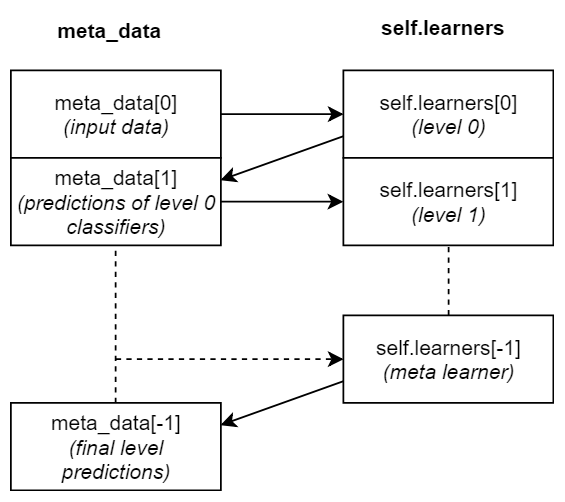

In [4]:
'''
For the test set, we do not need to split it into folds.
We simply train the base learners on the whole train set and predict on the test set.
Furthermore, we evaluate each base learner and store the evaluation metrics, in order to compare them with the ensemble's performance.
As this is a regression problem, we use R-squared and Mean Squared Error (MSE) as evaluation metrics
'''
# --- SECTION 4 ---
# Create the metadata for the test set and evaluate the base learners
test_meta_data = np.zeros((len(base_learners), len(test_x)))
base_errors = []
base_r2 = []
for i in range(len(base_learners)):
    learner = base_learners[i]
    learner.fit(train_x, train_y)
    predictions = learner.predict(test_x)
    test_meta_data[i] = predictions

    err = metrics.mean_squared_error(test_y, predictions)
    r2 = metrics.r2_score(test_y, predictions)

    base_errors.append(err)
    base_r2.append(r2)

test_meta_data = test_meta_data.transpose()

In [5]:
# --- SECTION 5 ---
# Fit the meta-learner on the train set and evaluate it on the test set
meta_learner.fit(meta_data, meta_targets)
ensemble_predictions = meta_learner.predict(test_meta_data)

err = metrics.mean_squared_error(test_y, ensemble_predictions)
r2 = metrics.r2_score(test_y, ensemble_predictions)

In [6]:
# --- SECTION 6 ---
# Print the results 
print('MSE   | R2 |Name')
print('-'*20)
for i in range(len(base_learners)):
    learner = base_learners[i]
    print(f'{base_errors[i]:.1f}|{base_r2[i]:.2f}|{learner.__class__.__name__}')
print(f'{err:.1f}|{r2:.2f}|Ensemble')

MSE   | R2 |Name
--------------------
2697.8|0.51|KNeighborsRegressor
3142.5|0.43|DecisionTreeRegressor
2564.8|0.54|Ridge
2064.7|0.63|Ensemble


As is evident, r-squared has improved by over 16% from the best base learner (ridge regression), while MSE has improved by almost 20%. This is a considerable improvement.


Additionally stacking regressor class of sklearn can also be used

# BAGGING

#### Bootstrapping
1. Bootstrapping is a resampling method.
2. In statistics, resampling entails the use of many samples, generated from an original sample.
3. In machine learning terms, the sample is our training data. The main idea is to use the original sample as the population (the whole domain of our problem) and the generated sub-samples as samples.

In essence, we are simulating how a statistic would behave if we collected many samples from the original population.
In order to create bootstrap samples, we resample with replacement (each instance may be selected multiple times) from our original sample


Bagging makes use of bootstrap samples in order to train an array of base learners.
It then combines their predictions using voting.
The motivation behind this method is to produce diverse base learners by diversifying the train sets.



<b>Creating base learners</b>
1. Bagging applies bootstrap sampling to the train set, creating a number of N bootstrap samples.
2. It then creates the same number N of base learners, using the <b>same machine learning algorithm </b>. 
3. Each base learner is trained on the corresponding train set and all base learners are combined by voting (hard voting for classification, and averaging for regression).

The procedure is depicted as follows:
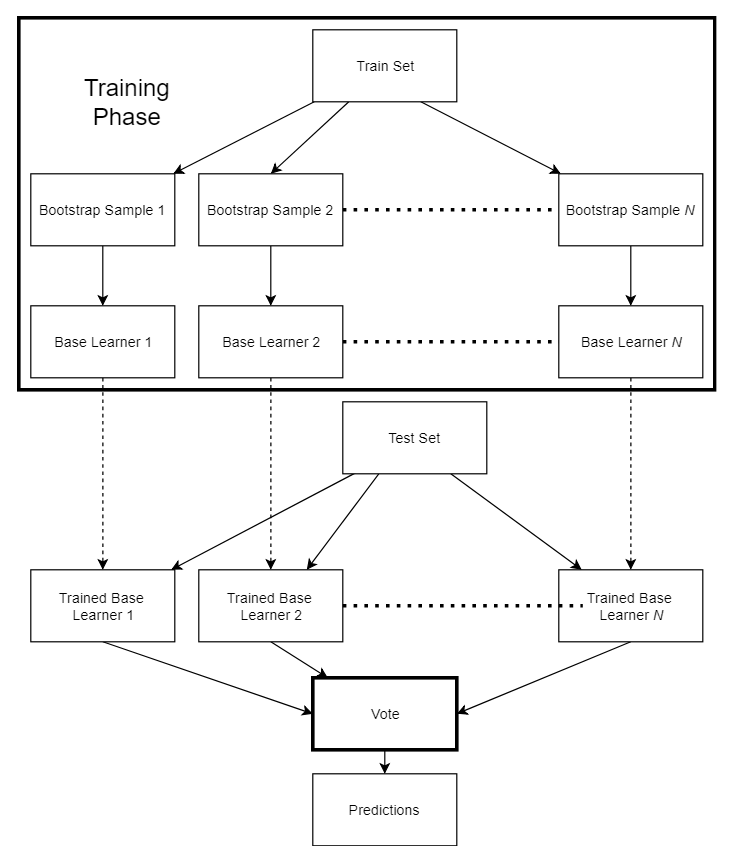



<b>Creating base learners through bagging</b>
1. By using bootstrap samples with the same size as the original train set, each instance has a probability of 0.632 of appearing in any given bootstrap sample. 
2. Thus, in many cases, this type of bootstrap estimate is referred to as the <b>0.632 bootstrap estimate</b> 
3. In our case, this means that we can use the remaining 36.8% of the original train set in order to estimate the individual base learner's performance.
4. This is called the out-of-bag score, and the 36.8% of instances are called out-of-bag instances.

Proof: if you call S a sample of n numbers from {1:n} drawn randomly and with replacement, S contains on average approximately (1−(1/e))n ≈ 0.63212056n unique elements.



#### Strengths
1. Bagging is usually utilized with decision trees as its base learners, but it can be used with any machine learning algorithm.
2. Bagging reduces variance greatly and it has been proved that it is most effective when unstable base learners are used.
3. Unstable learners generate models with great inter-model variance, even when the respective train sets vary only slightly.
4. Furthermore, bagging converges as the number of base learners grows.
5. Similar to estimating a bootstrap statistic, by increasing the number of base learners, we also increase the number of bootstrap samples. 
6. Finally, bagging allows for easy parallelization, as each model is trained independently.


#### Weaknesses
1. loss of interpretability and transparency of our models

For example, using a single decision tree allows for great interpretability, as the decision of each node is readily available. Using a bagging ensemble of 100 trees makes the individual decisions less important, while the collective predictions define the ensemble's final output.

In [7]:
### classification example -> mnist
'''
1500 instances as the train set
and the remaining 297 as the test set. 
We will generate 10 bootstrap samples, and consequently 10 decision-tree models.
We will then combine the base predictions using hard voting:
'''

# --- SECTION 1 ---
# Libraries and data loading
from sklearn.datasets import load_digits
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
import numpy as np
digits = load_digits()

train_size = 1500
train_x, train_y = digits.data[:train_size], digits.target[:train_size]
test_x, test_y = digits.data[train_size:], digits.target[train_size:]

In [8]:
# --- SECTION 2 ---
# Create our bootstrap samples and train the classifiers

ensemble_size = 10
base_learners = []


# we sample indices in order to access features and targets

for _ in range(ensemble_size):
    bootstrap_indices= np.random.randint(0, train_size, size= train_size)
    
    bootstrap_x = train_x[bootstrap_indices]
    bootstrap_y = train_y[bootstrap_indices]
    
    dt = DecisionTreeClassifier()
    dt.fit(bootstrap_x,  bootstrap_y)
    
    base_learners.append(dt)

In [9]:
# --- SECTION 3 ---
# Predict with the base learners and evaluate them

base_predictions = []
base_accuracy = []

for learner in base_learners:
    predictions = learner.predict(test_x)
    base_predictions.append(predictions)
    
    acc = metrics.accuracy_score(test_y, predictions)
    base_accuracy.append(acc)

In [10]:
# Combine the base learners' predictions using hardvoting
 
ensemble_predictions = []
# Find the most voted class for each test instance

for i in range(len(test_y)):
    votes = [0 for _ in range(10)]
    
    for learner_predictions in base_predictions:
        votes[learner_predictions[i]] = votes[learner_predictions[i]]+1
    
    # Find the class with most votes 
    final = np.argmax(votes)
    # Add the class to the final predictions 
    ensemble_predictions.append(final)
    

ensemble_acc = metrics.accuracy_score(test_y, ensemble_predictions)

In [11]:
# --- SECTION 5 ---
# Print the accuracies

print('Base Learners:')
print('-'*30)
for index, acc in enumerate(sorted(base_accuracy)):
    print(f'Learner {index+1}: %.2f' % acc)

print('-'*30)
print('Bagging: %.2f' % ensemble_acc)

Base Learners:
------------------------------
Learner 1: 0.73
Learner 2: 0.74
Learner 3: 0.74
Learner 4: 0.75
Learner 5: 0.76
Learner 6: 0.76
Learner 7: 0.78
Learner 8: 0.78
Learner 9: 0.79
Learner 10: 0.80
------------------------------
Bagging: 0.88


# BOOSTING

Boosting aims to combine a number of weak learners into a strong ensemble.
It is able to reduce bias, but also variance
Here, weak learners are individual models that perform slightly better than random.
For example, in a classification dataset with two classes and an equal number of instances belonging to each class, a weak learner will be able to classify the dataset with an accuracy of slightly more than 50%.

### ADABOOST (Adaptive Boosting)

create a number of uncorrelated weak learners and then combine their predictions.
The main difference with bagging is that instead of creating a number of independent bootstrapped train sets,
1. the algorithm sequentially trains each weak learner
2. assigns weights to all instances
3. samples the next train set based on the instance's weights
4. and repeats the whole process


##### Decision stumps
1. As a base learner algorithm, usually decision trees consisting of a single node are used. These decision trees, with a depth of a single level, are called <b>decision stumps.</b>
2. Decision Stumps are like trees in a Random Forest, but not "fully grown." They have one node and two leaves. AdaBoost uses a forest of such stumps rather than trees.
3. Stumps alone are not a good way to make decisions. A full-grown tree combines the decisions from all variables to predict the target value. A stump, on the other hand, can only use one variable to make a decision



Weighted sampling is the sampling process were each candidate has a corresponding weight, which determines its probability of being sampled. The weights are normalized, in order for their sum to equal one. Then, the normalized weights correspond to the probability that any individual will be sampled


#### Approach for classification

1. A weak classifier (e.g. a decision stump) is made on top of the training data based on the weighted samples. Here, the weights of each sample indicate how important it is to be correctly classified. Initially, for the first stump, we give <b>all the samples equal weights</b>

2. <b>We create a decision stump for each variable</b> and see how well each stump classifies samples to their target classes. For example, in the diagram below we check for Age, Eating Junk Food, and Exercise. We'd look at how many samples are correctly or incorrectly classified as Fit or Unfit for each individual stump.

3. <b>More weight is assigned to the incorrectly classified samples</b> so that they're classified correctly in the next decision stump. Weight is also assigned to each classifier based on the accuracy of the classifier, which means high accuracy = high weight!

4. Reiterate from Step 2 until all the data points have been correctly classified, or the maximum iteration level has been reached.

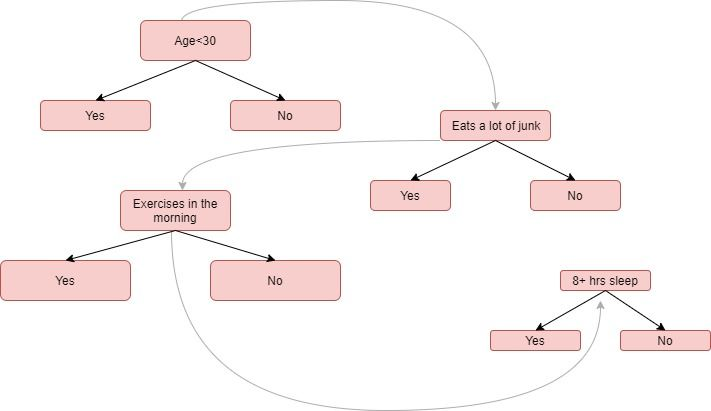


For regression purposes, the steps are similar:

1. Initialize all of the train set instance's weights equally, so their sum equals 1.
2. Generate a new set by sampling with replacement, according to the weights.
3. Train a weak learner on the sampled set.
4. Calculate its error on the original train set.
5. Add the weak learner to the ensemble and save its error rate.
6. Adjust the weights, increasing the weights of misclassified instances and decreasing the weights of correctly classified instances.
7. Repeat from Step 2.
8. The weak learners are combined by voting. Each learner's vote is weighted, according to its error rate.



#### Strengths and weaknesses
Boosting algorithms are able to reduce both bias and variance.

For a long time, they were considered immune to overfitting, but in fact they can overfit, although they are extremely robust.

One possible explanation is that the base learners, in order to classify outliers, create very strong and complicated rules that rarely fit other instances.

One disadvantage of many boosting algorithms is that they are not easily parallelized, as the models are created in a sequential fashion.

Furthermore, they pose the usual problems of ensemble learning techniques, such as reduction in interpretability and additional computational costs.

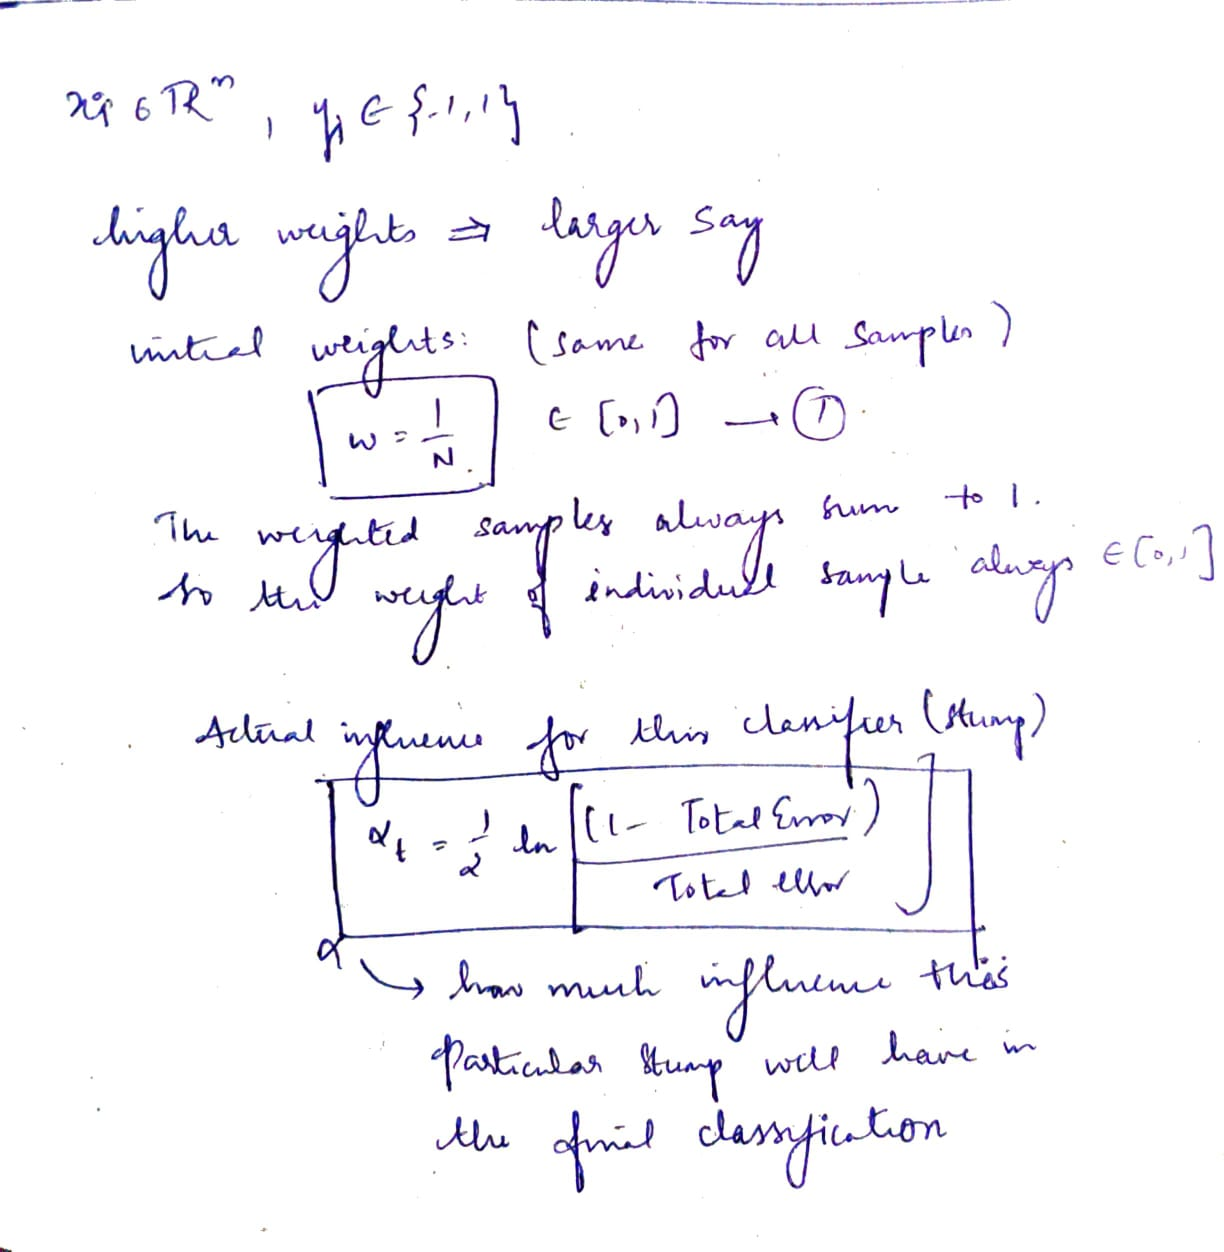




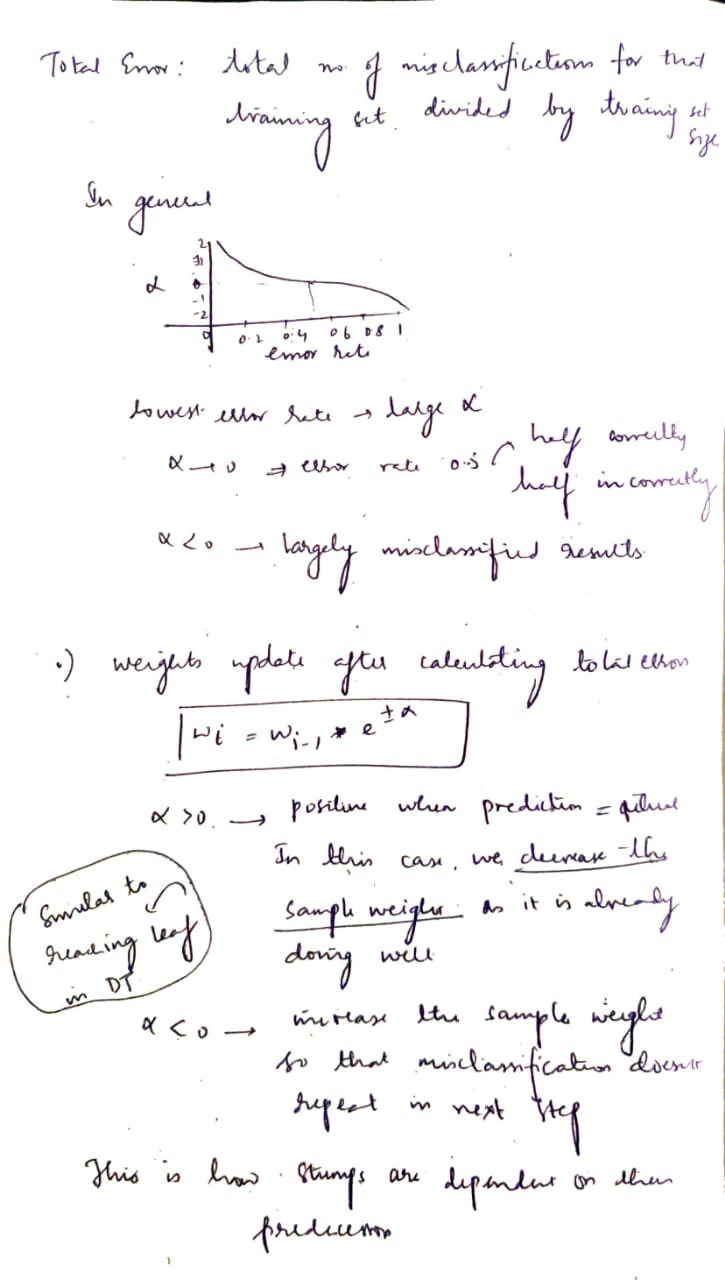


In [12]:
## Adaboost classification for breast cancer classification

# --- SECTION 1 ---
# Libraries and data loading
from copy import deepcopy
from sklearn.datasets import load_breast_cancer
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
import numpy as np


bc = load_breast_cancer()
train_size = 400
train_x, train_y = bc.data[:train_size], bc.target[:train_size]
test_x, test_y = bc.data[train_size:], bc.target[train_size:]
np.random.seed(123456)

In [13]:
# Creating the ensemble
ensemble_size = 3

base_classifier = DecisionTreeClassifier(max_depth=1)

#creating initial weights
data_weights = np.zeros(train_size) + 1/ train_size

# train_indices
indices = [ x for x in range(train_size)]


base_learners =[]

learners_errors = np.zeros(ensemble_size)
learners_weights = np.zeros(ensemble_size)

In [14]:
'''
For each base learner, we will create a deepcopy of the original classifier, train it on a sample dataset, and evaluate it. First, we create the copy and sample with replacement from the original test set, according to the instance's weights:
'''

# creating each base learner

for i in range(ensemble_size):
    weak_learner = deepcopy(base_classifier)
    
    # choose the samples by sampling with replacement
    # each instance's probability is dictated by its weight
    
    data_indices = np.random.choice(indices, train_size, p=data_weights)
    
    sample_x, sample_y = train_x[data_indices], train_y[data_indices]
    
    
    # fitting the weak learner and evaluating
    weak_learner.fit (sample_x, sample_y)
    
    predictions = weak_learner.predict(train_x)
    
    errors = predictions != train_y
    corrects = predictions == train_y
    
    
    # calculating weighted errors
    weighted_errors = data_weights * errors
    
    # base learner's error is the average of the weighted errors
    learner_error = np.mean(weighted_errors)
    learners_errors[i] = learner_error
    
    '''
    Finally, the learner's weight can be calculated as half the natural logarithm of the weighted accuracy over the weighted error.
    In turn, we can use the learner's weight to calculate the new data weights.
    For erroneously classified instances, the new weight equals the natural exponent of the old weight times the learner's weight.
    For correctly classified instances, the negative multiple is used instead.
    Finally, the new weights are normalized and the base learner is added to the base_learners list
    '''
    # The learner's weight
    learner_weight = np.log((1-learner_error)/learner_error)/2
    learners_weights[i] = learner_weight
    
    
    # Update the data weights
    data_weights[errors] = np.exp(data_weights[errors] * learner_weight)
    data_weights[corrects] = np.exp(-data_weights[corrects] * learner_weight)
    data_weights = data_weights/sum(data_weights)
    
    
    # Save the learner
    base_learners.append(weak_learner)

In [15]:
# --- SECTION 3 ---
# Evaluate the ensemble
ensemble_predictions = []
for learner, weight in zip(base_learners, learners_weights):
    # Calculate the weighted predictions
    prediction = learner.predict(test_x)
    ensemble_predictions.append(prediction*weight)

# The final prediction is the weighted mean of the individual predictions
ensemble_predictions = np.mean(ensemble_predictions, axis=0) >= 0.5

ensemble_acc = metrics.accuracy_score(test_y, ensemble_predictions)

# --- SECTION 4 ---
# Print the accuracy
print('Ada Boosting: %.2f' % ensemble_acc)

Ada Boosting: 0.95


## GRADIENT BOOSTING

It is a more generalized boosting framework compared to AdaBoost, which also makes it more complicated and math-intensive. 

<b>##</b> Instead of trying to emphasize problematic instances by assigning weights and resampling the dataset, gradient boosting builds each base learner on the previous learner's errors.

Furthermore, gradient boosting uses <b>decision trees of varying depths</b> not like decision stumps


#### Creating the ensemble
The gradient boosting algorithm (for regression purposes) starts by calculating the mean of the target variable for the train set and uses it as an initial prediction.
Then, it calculates the difference of each instance's target from the prediction (mean), in order to calculate the error. These errors are also called <b>pseudo-residuals</b>.

1. Following that, it creates a decision tree that tries to predict the pseudo-residuals.
2. By repeating this process, a number of times, the whole ensemble is created.
3. Similar to AdaBoost, gradient boosting assigns a weight to each tree.
4. Contrary to AdaBoost, this weight does not depend on the tree's performance. 
5. Instead, it is a constant term, which is called <b>learning rate</b>.
6. Its purpose is to increase the ensemble's generalization ability, by restricting its over-fitting power. 


#### Steps
```
1. Define the learning rate (smaller than 1) and the ensemble's size.
2. Calculate the train set's target mean.
3. Using the mean as a very simple initial prediction, calculate each instance's target difference from the mean. These errors are called pseudo-residuals.
4. Build a decision tree, by using the original train set's features and the pseudo-residuals as targets.
5. Make predictions on the train set, using the decision tree (we try to predict the pseudo-residuals). Multiply the predicted values by the learning rate.
6. Add the multiplied values to the previously stored predicted values. Use the newly calculated values as predictions.
7. Calculate the new pseudo-residuals using the calculated predictions.
8. Repeat from Step 4 until the desired ensemble size is achieved.
```

In [16]:
# --- SECTION 1 ---
# Libraries and data loading
from copy import deepcopy
from sklearn.datasets import load_diabetes
from sklearn.tree import DecisionTreeRegressor
from sklearn import metrics
import numpy as np


diabetes = load_diabetes()
train_size = 400
train_x, train_y = diabetes.data[:train_size], diabetes.target[:train_size]
test_x, test_y = diabetes.data[train_size:], diabetes.target[train_size:]
np.random.seed(123456)

In [17]:
# --- SECTION 2 ---
# Create the ensemble
# Define the ensemble's size, learning rate and decision tree depth
ensemble_size = 50
learning_rate = 0.1
base_classifier = DecisionTreeRegressor(max_depth=3)

# Create placeholders for the base learners and each step's prediction
base_learners = []

# Note that the initial prediction is the target variable's mean
previous_predictions = np.zeros(len(train_y)) + np.mean(train_y)

In [18]:
# Create the base learners

for _ in range(ensemble_size):
    # Start by calculating the pseudo-residuals
    errors = train_y - previous_predictions
    
    # Make a deep copy of the base classifier and train it on the
    # pseudo-residuals
    learner = deepcopy(base_classifier)
    
    learner.fit(train_x, errors)
    predictions = learner.predict(train_x)
    
    # Multiply the predictions with the learning rate and add the results
    # to the previous prediction
    previous_predictions +=  (learning_rate)*predictions
    # Save the base learner
    base_learners.append(learner)

In [19]:
# --- SECTION 3 ---
# Evaluate the ensemble
# Start with the train set's mean
previous_predictions = np.zeros(len(test_y)) + np.mean(train_y)
# For each base learner predict the pseudo-residuals for the test set and
# add them to the previous prediction, 
# after multiplying with the learning rate
for learner in base_learners:
    predictions = learner.predict(test_x)
    previous_predictions = previous_predictions + learning_rate*predictions

# --- SECTION 4 ---
# Print the metrics
r2 = metrics.r2_score(test_y, previous_predictions)
mse = metrics.mean_squared_error(test_y, previous_predictions)
print('Gradient Boosting:')
print('R-squared: %.2f' % r2)
print('MSE: %.2f' % mse)

Gradient Boosting:
R-squared: 0.59
MSE: 2253.34


## RANDOM FORESTS

Random Forests expand on bagging by inducing randomness not only on each base learner's train samples, but in the features as well.

Bagging is able to produce reasonably uncorrelated trees by diversifying each tree's train set through bootstrapping.
But bagging only diversifies the trees by acting on one axis: each set's instances.

There is still a second axis on which we can introduce diversity, the features.


By selecting a subset of the available features during training, the generated base learners can be even more diverse.

In random forests, for each tree and at each node, <b>only a subset of the available features </b> is considered when choosing the best feature/split point combination. 

The number of features that will be selected can be optimized by hand, but one-third of all features for regression problems and the square root of all features are considered to be a good starting point.


1. Select the number of features m that will be considered at each node
2. For each base learner, do the following:
        1. Create a bootstrap train sample
        2. Select the node to split
        3. Select m features randomly
        4. Pick the best feature and split point from m
        5. Split the node into two nodes
        6. Repeat from step 2-2 until a stopping criterion is met, such as maximum tree depth
        
        
        
        
### Extra trees
Another method to create trees in a Random Forest ensemble is Extra Trees (extremely randomized trees). The main difference with the previous method is that the feature and split point combination does not have to be the optimal. Instead, a number of split points are randomly generated, one for each available feature. The best split point of those generated is selected. The algorithm constructs a tree as follows:
```
Select the number of features m that will be considered at each node and the minimum number of samples n in order to split a node
For each base learner, do the following:
Create a bootstrap train sample
Select the node to split (the node must have at least n samples)
Select m features randomly
Randomly generate m split points, with values between the minimum and maximum value of each feature
Select the best of these split points
Split the node into two nodes and repeat from step 2-2 until there are no available nodes
```



### Creating forests
By creating a number of trees using any valid randomization method, we have essentially created a forest, hence the algorithm's name. After generating the ensemble's trees, their predictions must be combined in order to have a functional ensemble. 

This is usually achieved through <b>majority voting for classification problems and through averaging for regression problems</b>. 
There are a number of hyperparameters associated with Random Forests, such as the number of features to consider at each node split, the number of trees in the forest, and the individual tree's size. As mentioned earlier, a good starting point for the number of features to consider is as follows:

        The square root of the number of total features for classification problems
        One-third of the number of total features for regression problems
        
        
        
### Analyzing forests
Random Forests provide information about the underlying dataset that most of other methods cannot easily provide. A prominent example is the importance of each individual feature in the dataset. One method to estimate feature importance is to use the Gini index for each node of each tree and compare each feature's cumulative value. Another method uses the out-of-bag samples. First, the out-of-bag accuracy is recorded for all base learners. Then, a single feature is chosen and its values are shuffled in the out-of-bag samples. This results in out-of-bag sample sets with the same statistical properties as the original sets, but any predictive power that the chosen feature might have is removed (as there is now zero correlation between the selected feature's values and the target). The difference in accuracy between the original and the partially random dataset is used as measure for the selected feature's importance.

Concerning bias and variance, although random forests seem to cope well with both, they are certainly not immune. Bias can appear when the available features are great in number, but only few are correlated to the target. When using the recommended number of features to consider at each split (for example, the square root of the number of total features), the probability that a relevant feature will be selected can be small. The following graph shows the probability that at least one relevant feature will be selected, as a function of relevant and irrelevant features (when the square root of the number of total features is considered at each split)


Variance can also appear in Random Forests, although the method is sufficiently resistant to it. Variance usually appears when the individual trees are allowed to grow fully. We have previously mentioned that as the number of trees increases, the error approximates a certain limit. Although this claim still holds true, it is possible that the limit itself overfits the data. Restricting the tree size (by increasing the minimum number of samples per leaf or reducing the maximum depth) can potentially help in such circumstances.



### Strengths and weaknesses
Random Forests are a very robust ensemble learning method, able to reduce both bias and variance, similar to boosting. Furthermore, the algorithm's nature allows it to be fully parallelized, both during training, as well as during prediction. This is a considerable advantage over boosting methods, especially when large datasets are concerned. Furthermore, they require less hyperparameter fine-tuning, compared to boosting techniques, especially XGBoost.

The main weaknesses of random forests are their sensitivity to class imbalances, as well as the problem we mentioned earlier, which involves a low ratio of relevant to irrelevant features in the train set. Furthermore, when the data contains low-level non-linear patterns (such as in raw, high-resolution image recognition), Random Forests usually are outperformed by deep neural networks. Finally, Random Forests can be computationally expensive when very large datasets are used combined with unrestricted tree depth.

## XGBOOST

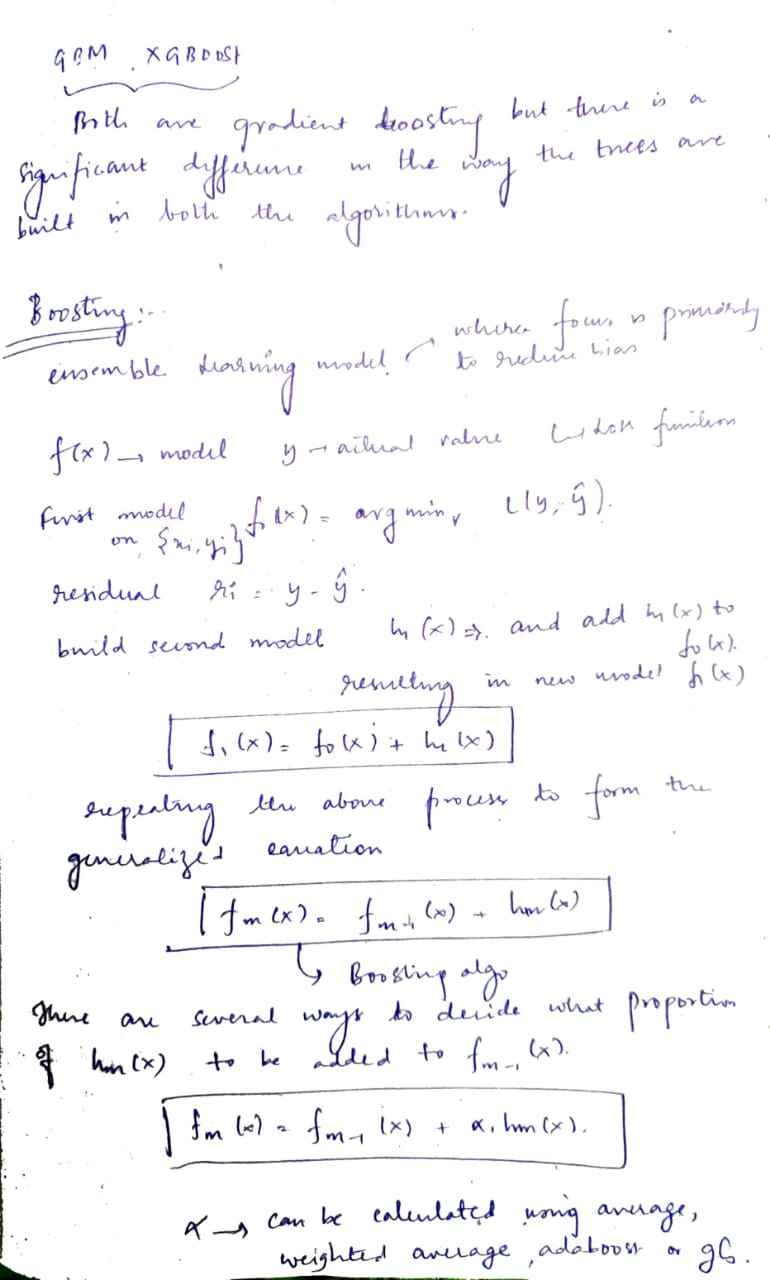

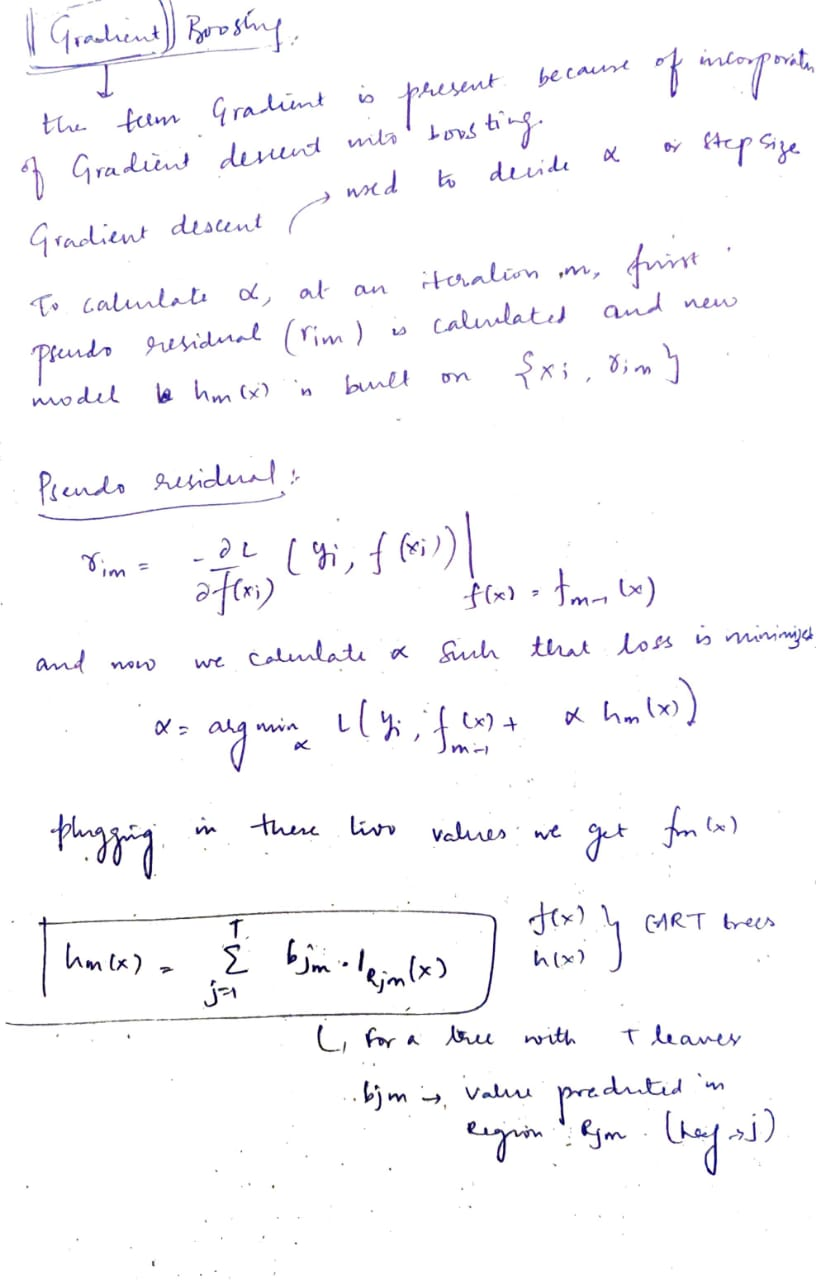

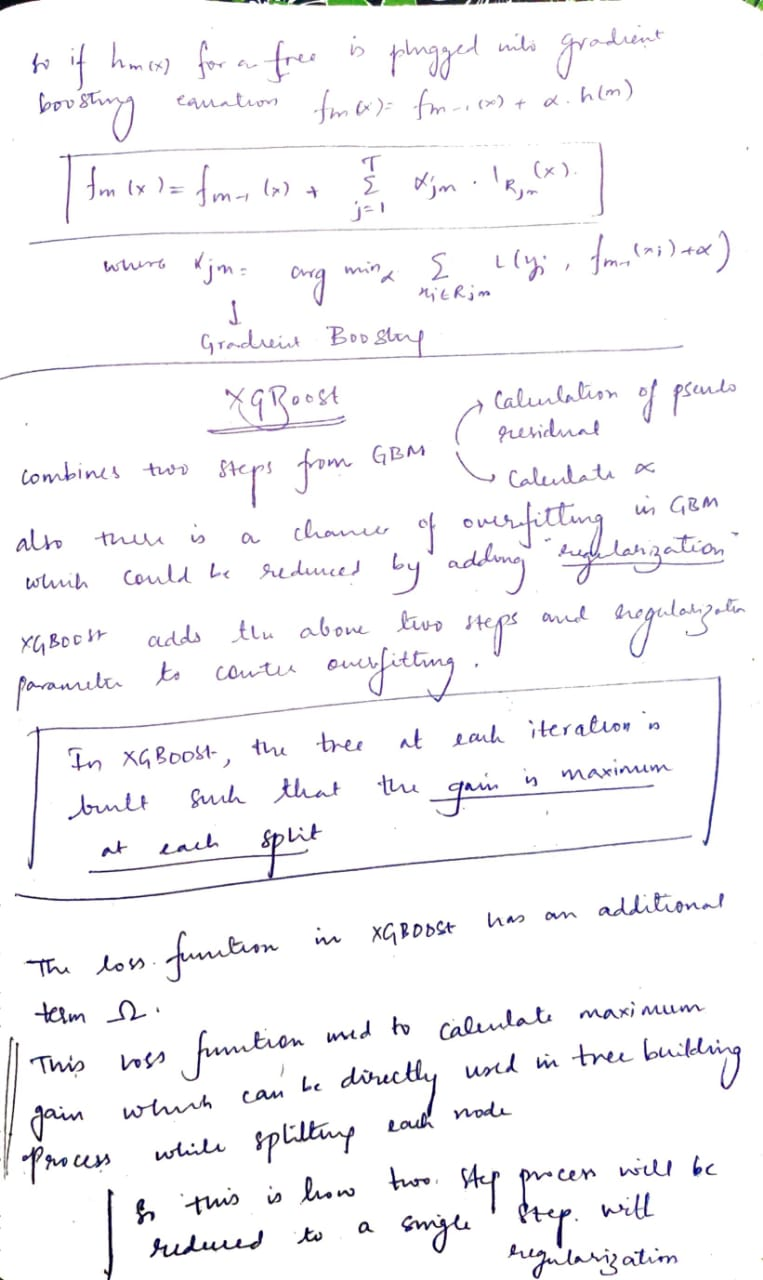

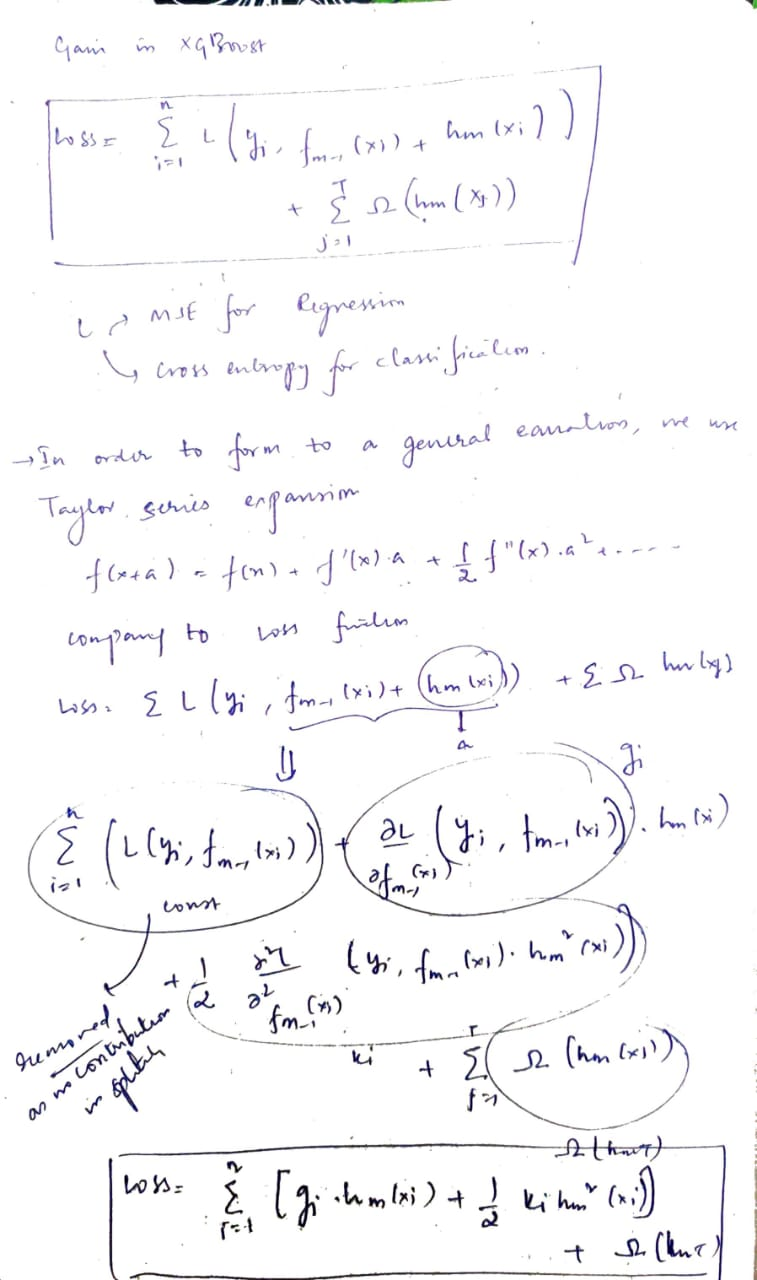

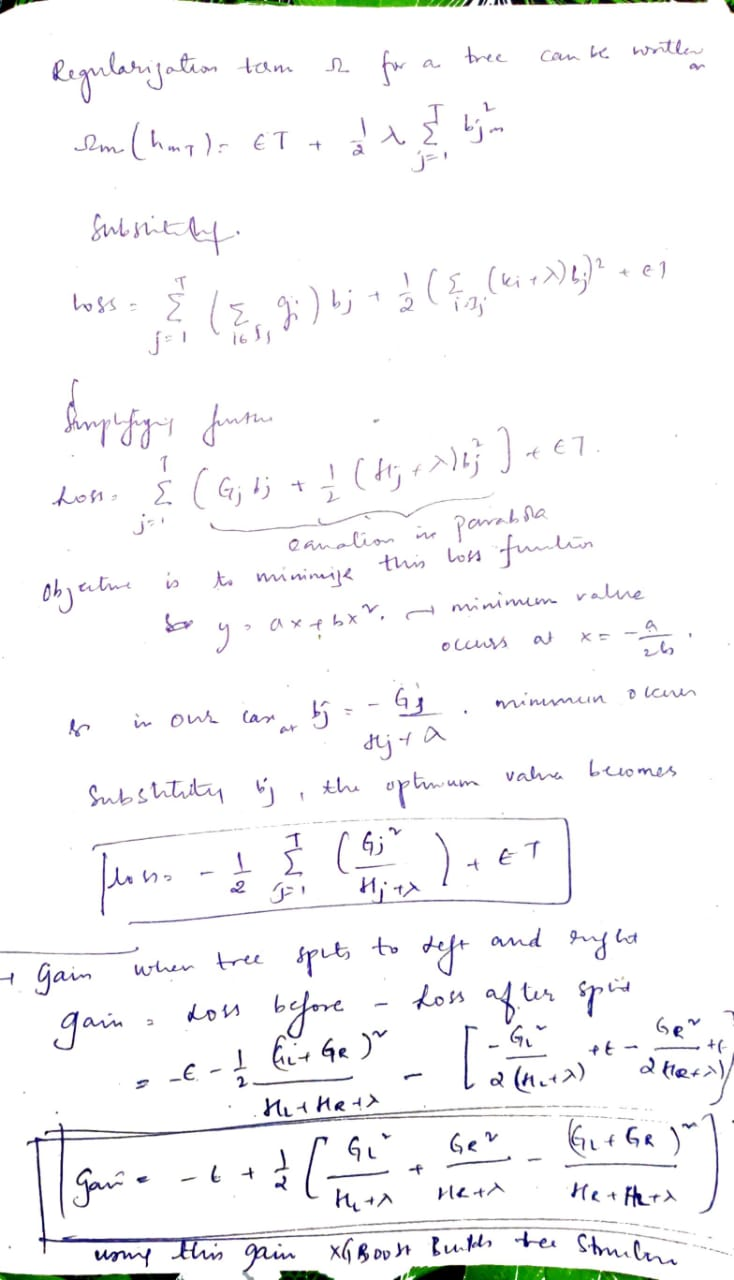